# QUANTITATIVE MACROECONOMICS: PROBLEM SET 4 - VALUE FUNCTION ITERATION
#### Marta Oliva Riera

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

## 1. Value function itertion with inelastic labour supply
The following is the recursive formulation of our problem:

$$ V(k) = {Max}_{c, k'} ln(c) - \kappa \frac{h^{1+\frac{1}{\nu}}}{1+\frac{1}{\nu}} + \beta V(k') $$

$$ s.t. c + k' = k^{1-\theta} - (1-\delta)k $$


### (a) Brute force iterations:
To solve the problem for the fixed point of the value function, I follow some steps:
1. Discretize the state space: I create 200 evenly spaced points for k between 1 and 1.5 times the steady state value of k.

2. Create the returns matrix (M). I make sure it is feasible by including the feasibility constraint $ c>0 $. Eah of M's elements is defined as:
$$ M_{ij} = m(k_i, k_j) = ln(k_i^{1-\theta} - (1-\delta)k_i - k_j) $$

3. Set up an initil guess for the value function, which for me is just  vector of zeros:
$$ V_0 (k) = 0 $$

4. Value function iteration: based on the initial guess, I create the $\chi$ matrix, whose elements are $\chi_{ij} = M_{ij} + \beta V_j^S$, where S is the number of iterations. The maximum value of each row in $\chi$ creates the updated value function, as well as the decision rule (g): 
$$ V^{s+1} = max(\chi) $$
$$ g = argmax(\chi) $$

5. Check for convergence of the value functions: if $|V^{s+1} - V^s| < \varepsilon$, they have converged; if not I repeat step 4 until there is convergence.

The results are presented below the code.


TOC: Elapsed: 0:00:54.20


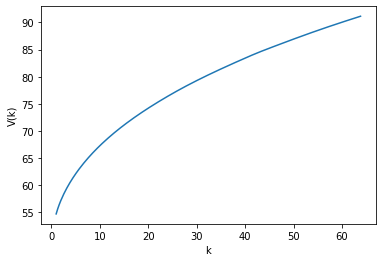

Convergence of the value functions took 371 iterations, in 54.2015266418457 seconds.


In [11]:
#%% ===========================================================================
# 1. VFI with inelastic labour supply
# =============================================================================
# parameters + labour supply:
theta = 0.679
beta = 0.988
delta = 0.013
kappa = 5.24
nu = 2.0

h = 1   # inelastic labour supply

# (a) Brute force Value Function Iteration 
#------------------------------------------------------------------------------
# Discretize the state space: 
qe.tic()
kSS = ((1/beta-1+delta)/(1-theta))**(-1/theta)
nk = 200
k = np.linspace(1, 1.5*kSS, nk)   # nk evenly spaced points

# Returns matrix:
M = np.empty([nk,nk])
for i,ki in enumerate(k):
        for j, kj in enumerate(k):
            if kj <= ki**(1- theta) + (1-delta)*ki:   # using only feasible values (c>0)
                M[i,j]  = np.log(ki**(1- theta) + (1-delta)*ki - kj)   # omitting the labour part of u()
            else:
                M[i,j] = -1000000

# Value function iteration:
epsilon = 0.01 
convergence = False
s = 0
S = 500
X = np.empty([nk, nk])
g = np.ones([nk, 1])
Vi = np.zeros([nk,1])   # initial value function guess
Vj = np.empty([nk,1])

while (s<S) and (convergence == False):
    for i in range(nk):
        for j in range(nk):
            X[i,j] = M[i,j] + beta*Vi[j]
    for i in range(nk):
        Vj[i] = np.max(X[i,:])
        g[i] = np.argmax(X[i,:])
    if np.max(Vj - Vi) >= epsilon:
        Vi = np.copy(Vj)
        Vj = np.empty([nk,1])
        s += 1
    else:
        convergence = True
        
# Policy functions:
gk = np.empty(nk)
gc = np.empty(nk)
for i in range(nk):
    gk[i] = k[int(g[i])]
    gc[i] = k[i]**(1- theta) + (1-delta)*k[i] - gk[i]

T = qe.toc()

# Plotting:
plt.plot(k, Vj, label='V(k)')  
plt.xlabel('k')
plt.ylabel('V(k)')
plt.show()

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")  

Convergence takes quite long in this case. The next sections will reduce the time by taking advantage of some properties of the value function and the decision rules, as well as using other methods (policy function iteration).

### (b) Monotonicity of the decision rule:

Here I repeat the same steps as in the previous case but I add a lower bound of the decision rule ($g^{LB}$) such that the $\chi$ matrix will only be computed for those pairs of $(k_i,k_j)$ which satisfy the lower bound: $k_j >= g^{LB}(k_i)$.

As can be seen in the results below the code, that speeds up the convergence process by a bit over 10 seconds.


TOC: Elapsed: 0:00:41.22


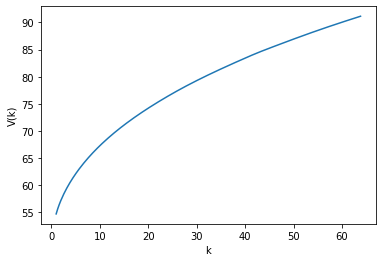

Convergence of the value functions took 371 iterations, in 41.228310108184814 seconds.


In [12]:
#%% (b) Monotonicity of the optimal decision rule 
#------------------------------------------------------------------------------
# Value function iteration:
qe.tic()
epsilon = 0.01 
convergence = False
s = 0
S = 500
g = np.ones([nk, 1])    
X = np.zeros([nk, nk])
Vi = np.zeros([nk,1])   # initial value function guess
Vj = np.empty([nk,1])   # empty updated value function

while (s<S) and (convergence == False):
    for i in range(nk):
        for j in range(nk):
            gLB = int(g[i])    # lower bound of the decision rule
            if j+gLB < nk:     # monotonicity
                X[i,j+gLB] = M[i,j+gLB] + beta*Vi[j+gLB]
            else:
                continue
    for i in range(nk):
        Vj[i] = np.max(X[i,:])
        g[i] = np.argmax(X[i,:])
    if np.max(Vj - Vi) >= epsilon:
        Vi = np.copy(Vj)
        Vj = np.empty([nk,1])
        s += 1
    else:
        convergence = True

T = qe.toc()

# Plotting:
plt.plot(k, Vj, label='V(k)')    
plt.xlabel('k')
plt.ylabel('V(k)')
plt.show()

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")  
    

### (c) Concavity of the value function:

Another possibility to speed up the iteration process is to use the fact that the value function is strictly concave in k, such that if:

$$ M_{i,j} + \beta V_j > M_{i,j+1} + \beta V_{j+1} $$

then 

$$ M_{i,j} + \beta V_j > M_{i,j+2} + \beta V_{j+2} $$

As a result, we do not need to compute all elements of the $\chi$ matrix: for each row i, once we find $\chi_{i,j-1} > \chi_{i,j}$ we can omit the computation of the subsequent elements, as the maximand will be $\chi_{i,j-1}$.

This also speeds up the iterations when compared to the brute force case, even more than monotonicity did.

TOC: Elapsed: 0:00:30.85


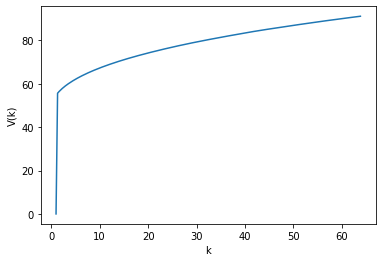

Convergence of the value functions took 371 iterations, in 30.85150122642517 seconds.


In [13]:
#%% (c) Concavity of the value function 
#------------------------------------------------------------------------------
qe.tic()
nk=200
# Value function iteration:
epsilon = 0.01 
convergence = False
s = 0
S = 500
X = np.zeros([nk, nk])
g = np.ones([nk, 1])
Vi = np.zeros([nk,1])   # initial value function guess
Vj = np.empty([nk,1])

while (s<S) and (convergence == False):
    for i in range(nk):
        for j in range(nk):
            X[i,j] = M[i,j] + beta*Vi[j]
            if X[i,j] < X[i,j-1]:   # concavity property
                break
    for i in range(nk):
        Vj[i] = np.max(X[i,:])
        g[i] = np.argmax(X[i,:])
    if np.max(Vj - Vi) >= epsilon:
        Vi = np.copy(Vj)
        Vj = np.empty([nk,1])
        s += 1
    else:
        convergence = True

T = qe.toc()

# Plotting:
plt.plot(k, Vj, label='V(k)')     
plt.xlabel('k')
plt.ylabel('V(k)')
plt.show()

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")  


### (d) Local search on the decision rule:

Now I will use local search on the decision rule, another way of not computing as many elements of the $\chi$ matrix in order to speed up the iterations. It is based on the fact that if $k_j = g(k_i)$ and we have a fine enough grid for k, then $g(k_{i+1})$ will be in a small neighbourhood of $k_j$.

The results show only a reduction of around 10 seconds in the iteration time when compared to the brute force iterations.

TOC: Elapsed: 0:00:48.48


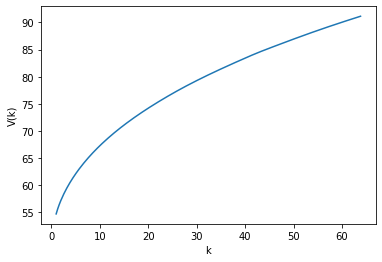

Convergence of the value functions took 372 iterations, in 48.48438906669617 seconds.


In [14]:
#%% (d) Local search on the decision rule 
#------------------------------------------------------------------------------
qe.tic()
# Value function iteration:
epsilon = 0.01 
convergence = False
s = 0
S = 500
X = np.zeros([nk, nk])
g = np.ones([nk, 1])
Vi = np.zeros([nk,1])   # initial value function guess
Vj = np.empty([nk,1])

while (s<S) and (convergence == False):
    for i in range(nk):
        for j in range(nk):
            if (j >= g[i]) and (j <= g[i] + 5) :    # local search
                X[i,j] = M[i,j] + beta*Vi[j]
    for i in range(nk):
        Vj[i] = np.max(X[i,:])
        g[i] = np.argmax(X[i,:])
    if np.max(Vj - Vi) >= epsilon:
        Vi = np.copy(Vj)
        Vj = np.empty([nk,1])
        s += 1
    else:
        convergence = True

T = qe.toc()

# Plotting:
plt.plot(k, Vj, label='V(k)')       
plt.xlabel('k')
plt.ylabel('V(k)')
plt.show()

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")  



### (e) Monotonicity and concavity:

Using both monotonicity of the decision rule and concavity of the value function at the same time results in cutting the convergence process time by half when compared to the brute force case.

TOC: Elapsed: 0:00:23.47


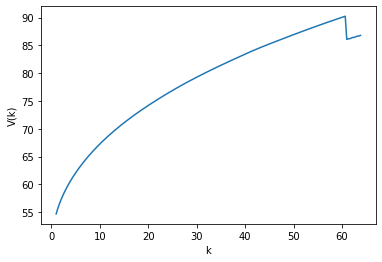

Convergence of the value functions took 371 iterations, in 23.470237731933594 seconds.


In [15]:
#%% (e) Concavity + Monotonicity 
#------------------------------------------------------------------------------
# Value function iteration:
qe.tic()
epsilon = 0.01 
convergence = False
s = 0
S = 500
g = np.ones([nk, 1])    
X = np.zeros([nk, nk])
Vi = np.zeros([nk,1])   # initial value function guess
Vj = np.empty([nk,1])   # empty updated value function

while (s<S) and (convergence == False):
    for i in range(nk):
        for j in range(nk):
            gLB = int(g[i])    # lower bound of the decision rule
            if j+gLB < nk:     # monotonicity of the decision rule
                X[i,j+gLB] = M[i,j+gLB] + beta*Vi[j+gLB]
                if X[i,j] < X[i,j-1]:   # concavity property
                    break
            else:
                continue
    for i in range(nk):
        Vj[i] = np.max(X[i,:])
        g[i] = np.argmax(X[i,:])
    if np.max(Vj - Vi) >= epsilon:
        Vi = np.copy(Vj)
        Vj = np.empty([nk,1])
        s += 1
    else:
        convergence = True

T = qe.toc()

# Plotting:
plt.plot(k, Vj, label='V(k)')     
plt.xlabel('k')
plt.ylabel('V(k)')
plt.show()

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")  


### (f) Howard's policy function iteration:

This method consists on iterating on the policy functions instead of on the value function. To use it, you make an initial guess on the policy function which you use to update the value function several times. Then you update the policy function, and if it has not converged you repeat the process. 

I started writing the code for this one but could not finish it, it would require some more work.

In [16]:
#%% (f) Howard's policy function iterations 
#------------------------------------------------------------------------------
qe.tic()

# discretize the state space:
kSS = ((1/beta-1+delta)/(1-theta))**(-1/theta)
nk = 100
k = np.linspace(1, 1.5*kSS, nk)   # nk evenly spaced points

# Initial guesses and empty matrices:
g0 = np.transpose(np.arange(0,100))    # Initial decision rule guess
g = np.empty([nk, 1])  # empty matrix to update the guess

gki = np.empty([nk, 1])
gkj = np.empty([nk, 1])
gc = np.empty([nk, 1])

# Policy function iteration:
epsilon = 0.01 
convergence = False
s = 0
S = 500
X = np.empty([nk, nk])
V0 = np.zeros([nk,1])
V = np.empty([nk,1])
# Policy iteration: 
while (s < S) and (convergence == False):
    for i in range(nk):
        gki[i] = k[int(g0[i])]
        gc[i] = k[i]**(1- theta) + (1-delta)*k[i] - gki[i]
        V[i] = np.max(np.log(gc[i]) + beta*V0[i])
        g[i] = np.argmax(np.log(gc[i]) + beta*V0[i])   # new decision rule
    for i in range(nk):
        gkj[i] = k[int(g[i])]
        gc[i] = k[i]**(1- theta) + (1-delta)*k[i] - gkj[i]    
    if np.max(gkj - gki)>= epsilon:
        gki = np.copy(gkj)
        gkj = np.empty([nk,1])
        s += 1
    else:
        convergence = True

## 2. Value function iteration with discrete labour choice:

Solving the same problem but now adding the possibility for agents to choose the amount of labour they provide. To solve this I just slightly modified the brute force iteration code. The results are presented below: convergence of the value function takes more iterations than it did in the inelastic labour case, and as a result also a bit more time. Applying the rest of methods in the previous question would speed it up.

TOC: Elapsed: 0:01:30.99


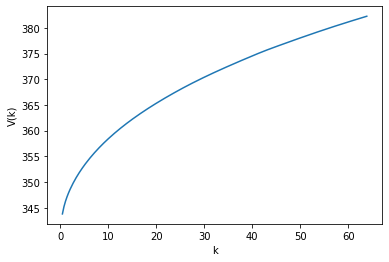

Convergence of the value functions took 504 iterations, in 90.99091625213623 seconds.


In [17]:
#%% ===========================================================================
# 2. VFI with labour choice
# =============================================================================
# parameters + labour supply:
theta = 0.679
beta = 0.988
delta = 0.013
kappa = 5.24
nu = 2.0

# Brute force Value Function Iteration 
#------------------------------------------------------------------------------
# Discretize the state space, now also for h: 
qe.tic()
kSS = ((1/beta-1+delta)/(1-theta))**(-1/theta)
nk = 200
nh = 50
k = np.linspace(0.5, 1.5*kSS, nk)   # nk evenly spaced points
h = np.linspace(0.01, 1, nh)   # nh evenly spaced points

# Returns matrix:
M = np.empty([nk,nk, nh])
for i,ki in enumerate(k):
        for j, kj in enumerate(k):
            for l, hl in enumerate(h):
                if kj <= ki**(1- theta) + (1-delta)*ki:   # using only feasible values (c>0)
                    M[i,j,l]  = np.log(ki**(1- theta) + (1-delta)*ki - kj) + kappa*(hl**(1+(1/nu))/(1+(1/nu)))
                else:
                    M[i,j,l] = -1000000

# Value function iteration:
epsilon = 0.01 
convergence = False
s = 0
S = 800
X = np.empty([nk, nk, nh])
g = np.ones([nk, 1])
Vi = np.zeros([nk,1])   # initial value function guess
Vj = np.empty([nk,1])
gk = np.empty(nk)
gh = np.empty(nh)
gc = np.empty(nk)

while (s<S) and (convergence == False):
    for i in range(nk):
        for j in range(nk):
            X[i,j] = M[i,j] + beta*Vi[j]
    for i in range(nk):
        Vj[i] = np.max(X[i,:,:])
        gk[i] = k[np.unravel_index(np.argmax(X[i,:,:], axis=None), X[i,:,:].shape)[0]]
        gc[i] =  k[i]**(1- theta) + (1-delta)*k[i] - gk[i]    
    for i in range(nh):
        gh[i] = h[np.unravel_index(np.nanargmax(X[i,:,:], axis=None), X[i,:,:].shape)[1]]
    if np.max(Vj - Vi) >= epsilon:
        Vi = np.copy(Vj)
        Vj = np.empty([nk,1])
        s += 1
    else:
        convergence = True
        


T = qe.toc()

# Plotting:
plt.plot(k, Vj, label='V(k)')     
plt.xlabel('k')
plt.ylabel('V(k)')    
plt.show()

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")  
